---

# IMPORTANT

**Please remember to save this notebook `dropout.ipynb` and `layers.py` as you work on them!**

---

In [11]:
# this mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# 請輸入 SC201_L12 資料夾之所在位置
FOLDERNAME = '我的 筆記型電腦 MSI/Research data/stanCodeML/L13'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/Othercomputers/{}'.format(FOLDERNAME))

# this downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd drive/Othercomputers/$FOLDERNAME/sc201/datasets/
!bash get_datasets.sh
%cd /content

Mounted at /content/drive
/content/drive/Othercomputers/我的 筆記型電腦 MSI/Research data/stanCodeML/L13/sc201/datasets
--2022-03-06 04:03:40--  http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  42.8MB/s    in 4.4s    

2022-03-06 04:03:44 (36.7 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1
/content


In [13]:
# As usual, a bit of setup
%cd drive/Othercomputers/$FOLDERNAME
from __future__ import print_function
import time
import numpy as np
import matplotlib.pyplot as plt
from sc201.classifiers.fc_net import *
from sc201.data_utils import get_CIFAR10_data
from sc201.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from sc201.solver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

/content/drive/Othercomputers/我的 筆記型電腦 MSI/Research data/stanCodeML/L13
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data()
for k, v in data.items():
  print('%s: ' % k, v.shape)

X_train:  (49000, 3, 32, 32)
y_train:  (49000,)
X_val:  (1000, 3, 32, 32)
y_val:  (1000,)
X_test:  (1000, 3, 32, 32)
y_test:  (1000,)


# Modular Design of Neural Networks

大家在上一份作業裡寫出了一套 fully-connected two-layer neural network，這套網路的架構算是比較簡單，可以透由單一函數來計算 loss 與 gradients。不過要能夠建立更複雜更多層的神經網路，我們必須將網路的架構模組化，將每一層分開定義，再將其拼湊在一起，組合成不同的 network。

模組化的原則如下：

我們分開定義每一種 layer 類型（如 affine、relu、normalization、dropout、softmax），為每一層定義 `forward` 及 `backward` 函數。`forward` 函數會接收前一層的輸出結果和本層要使用的權重等參數，計算並回傳本層的 output，也同時將 backward pass 計算梯度會需要的資訊儲存在一個 cache 中並將其回傳：

```python
def layer_forward(x, p):
  """ Receive inputs x and parameters p """
  # Do some computations ...
  z = # ... some intermediate value
  # Do some more computations ...
  out = # the output
   
  cache = (x, p, z, out) # Values we need to compute gradients
   
  return out, cache
```

而 `backward` 函數會接收 cost function 對於下一層的梯度以及 forward pass 回傳的 `cache` 物件，計算並回傳 cost function 對於本層的梯度。

```python
def layer_backward(dout, cache):
  """
  Receive dout (derivative of loss with respect to outputs) and cache,
  and compute derivative with respect to inputs.
  """
  # Unpack cache values
  x, p, z, out = cache
  
  # Use values in cache to compute derivatives
  dx = # Derivative of loss with respect to x
  dp = # Derivative of loss with respect to p
  
  return dx, dp
```

有了這些 layer，要怎麼組合出完整的 neural network？以作業4的 `TwoLayerNet` 為例，它的架構就會是 affine - relu - affine - softmax。我們會在神經網路初始化時定義它的權重 W1、W2 及偏差 b1、b2。

執行 forward pass 的時候，我們將 input X (圖像的畫素) 丟入第一層 affine layer 的 affine_forward 函數，然後將這一層的輸出結果丟入 relu_forward，以此類推，直到最後用 softmax_forward 及 input 的 true label y 計算出網路的預測與正確標籤之間的 cost。

`affine_forward(X, W1, b1)` $\rightarrow$ `relu_forward(...)` $\rightarrow$ `affine_forward(..., W2, b2)`  $\rightarrow$ `softmax_forward(..., y)` $\rightarrow$ $J$

這個流程中產生的所有 cache 我們會先儲存起來。執行 backward pass 的時候，我們會將 cost 以及 softmax 在 forward pass 產生的 cache 丟入 `softmax_backward`。這個函數輸出的結果會是 cost function 對於第二層 affine layer 的 output 之梯度。我們再將這個梯度及第二層 affine layer 的 cache 丟入 `affine_backward`，得到 cost function 對於 relu 結果、W2 和 b2的梯度，以此類推，最後計算出 cost function 對於所有參數 W1、b1、W2和 b2 的梯度。這些梯度就可以拿來做 gradient descent 的 update。

$J$ $\rightarrow$ `softmax_backward(..., cache_softmax)` $\rightarrow$ `affine_backward(..., cache_affine2)` $\rightarrow$ `relu_backward(..., cache_relu)` (and $dJ/dW2$, $dJ/db2$) $\rightarrow$ `affine_backward(..., cache_affine1)` $\rightarrow$ $dJ/dX$ (and $dJ/dW1$, $dJ/db1$)

最後要使用模型做預測時，我們可以執行 forward pass，在計算完第二層 `affine_forward` 後提前終止，找出這層輸出的 class scores 中最高的對應類別。

要建立更複雜的 neural network 的話，我們只需將適當的 `forward` 及 `backward` 函數插入上方流程即可！

# Example module with `affine`

請打開 `layers.py` 並詳讀 `affine_forward` 及 `affine_backward` 函數，以了解其運作原理。

# ReLU activation: forward
請寫出 `layers.py` 檔案中的 `relu_forward` 函數，然後執行下方 code 以做檢查

In [15]:
# Test the relu_forward function

x = np.linspace(-0.5, 0.5, num=12).reshape(3, 4)

out, _ = relu_forward(x)
correct_out = np.array([[ 0.,          0.,          0.,          0.,        ],
                        [ 0.,          0.,          0.04545455,  0.13636364,],
                        [ 0.22727273,  0.31818182,  0.40909091,  0.5,       ]])

# Compare your output with ours. The error should be on the order of e-8
print('Testing relu_forward function:')
print('difference: ', rel_error(out, correct_out))

Testing relu_forward function:
difference:  4.999999798022158e-08


# ReLU activation: backward
請完成同個檔案中的 `relu_backward` 函數，然後執行下方 code 以檢查 gradient 數值。

In [16]:
np.random.seed(231)
x = np.random.randn(10, 10)
dout = np.random.randn(*x.shape)

dx_num = eval_numerical_gradient_array(lambda x: relu_forward(x)[0], x, dout)

_, cache = relu_forward(x)
dx = relu_backward(dout, cache)

# The error should be on the order of e-12
print('Testing relu_backward function:')
print('dx error: ', rel_error(dx_num, dx))

Testing relu_backward function:
dx error:  3.2756349136310288e-12


# Dropout forward pass
Dropout 是神經網路的一種標準化 (regularization) 方式，在 forward pass 的流程中會將前一層輸出結果的其中一些數值隨機重設為零 [1] 。

[1] [Geoffrey E. Hinton et al, "Improving neural networks by preventing co-adaptation of feature detectors", arXiv 2012](https://arxiv.org/abs/1207.0580)

請寫出 `layers.py` 檔案中的 `dropout_forward` 函數，然後執行下方 code 以做檢查。記得 dropout 在 training 和 testing 階段的運作模式不同。

In [17]:
np.random.seed(231)
x = np.random.randn(500, 500) + 10

for p in [0.25, 0.4, 0.7]:
  out, _ = dropout_forward(x, {'mode': 'train', 'p': p})
  out_test, _ = dropout_forward(x, {'mode': 'test', 'p': p})

  print('Running tests with p = ', p)
  print('Mean of input: ', x.mean())
  print('Mean of train-time output: ', out.mean())
  print('Mean of test-time output: ', out_test.mean())
  print('Fraction of train-time output set to zero: ', (out == 0).mean())
  print('Fraction of test-time output set to zero: ', (out_test == 0).mean())
  print()

Running tests with p =  0.25
Mean of input:  10.000207878477502
Mean of train-time output:  10.014059116977283
Mean of test-time output:  10.000207878477502
Fraction of train-time output set to zero:  0.749784
Fraction of test-time output set to zero:  0.0

Running tests with p =  0.4
Mean of input:  10.000207878477502
Mean of train-time output:  9.977917658761159
Mean of test-time output:  10.000207878477502
Fraction of train-time output set to zero:  0.600796
Fraction of test-time output set to zero:  0.0

Running tests with p =  0.7
Mean of input:  10.000207878477502
Mean of train-time output:  9.987811912159426
Mean of test-time output:  10.000207878477502
Fraction of train-time output set to zero:  0.30074
Fraction of test-time output set to zero:  0.0



## Inline Question 1:
Please explain why your results in the above cell makes sense.

## Answer:
[FILL THIS IN]

## Inline Question 2:
What happens if we do not divide the values being passed through dropout by `p` in the dropout layer? Why does that happen?

## Answer:
[FILL THIS IN]

# Dropout backward pass
請完成同個檔案中的 `dropout_backward` 函數，然後執行下方 code 以檢查 gradient 數值。

In [18]:
np.random.seed(231)
x = np.random.randn(10, 10) + 10
dout = np.random.randn(*x.shape)

dropout_param = {'mode': 'train', 'p': 0.2, 'seed': 123}
out, cache = dropout_forward(x, dropout_param)
dx = dropout_backward(dout, cache)
dx_num = eval_numerical_gradient_array(lambda xx: dropout_forward(xx, dropout_param)[0], x, dout)

# Error should be around e-10 or less
print('dx relative error: ', rel_error(dx, dx_num))

dx relative error:  5.44560814873387e-11


# Fully-connected nets with Dropout
我們在 `classifiers/fc_net.py` 檔案裡已經用 modular design 幫大家組合出一個更強大的 `FullyConnectedNet` 神經網路。這個網路的架構是：

`{affine - batch/layer norm - relu - dropout} x (L - 1) - affine - softmax`

我們可以任意決定網路 layer 的數目 $L$。這裡使用的 relu 和 dropout layers 是大家上面完成的模組。網路的 constructor 用法如下：

```python
FullyConnectedNet(hidden_dims, input_dim, num_classes, dropout, normalization,
                  reg, weight_scale, dtype, seed)
```

`hidden_dims` 儲存網路所有 hidden (affine) layers 的大小，所以 `len(hidden_dims) = L`。`dropout` 決定 dropout layers 的 `p` 參數，如果 `dropout` 為一，我們就略過 dropout layers。

請詳讀並執行以下 code 以了解 `FullyConnectedNet` 的使用方式。

In [19]:
np.random.seed(231)
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for dropout in [1, 0.75, 0.5]:
  print('Running check with dropout = ', dropout)
  model = FullyConnectedNet([H1, H2], input_dim=D, num_classes=C,
                            weight_scale=5e-2, dtype=np.float64,
                            dropout=dropout, seed=123)

  loss, grads = model.loss(X, y)
  print('Initial loss: ', loss)
  
  # Relative errors should be around e-6 or less; Note that it's fine
  # if for dropout=1 you have W2 error be on the order of e-5.
  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
    print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))
  print()

Running check with dropout =  1
Initial loss:  2.3004790897684924
W1 relative error: 1.48e-07
W2 relative error: 2.21e-05
W3 relative error: 3.53e-07
b1 relative error: 5.38e-09
b2 relative error: 2.09e-09
b3 relative error: 5.80e-11

Running check with dropout =  0.75
Initial loss:  2.302371489704412
W1 relative error: 1.90e-07
W2 relative error: 4.76e-06
W3 relative error: 2.60e-08
b1 relative error: 4.73e-09
b2 relative error: 1.82e-09
b3 relative error: 1.70e-10

Running check with dropout =  0.5
Initial loss:  2.3042759220785896
W1 relative error: 3.11e-07
W2 relative error: 1.84e-08
W3 relative error: 5.35e-08
b1 relative error: 5.37e-09
b2 relative error: 2.99e-09
b3 relative error: 1.13e-10



# Regularization experiment

現在大家來做個實驗！我們先建立兩套 two-layer network，第一個不使用 dropout，而第二個則隨機保留 ~25% 的神經元。我們接著使用 CIFAR-10 的一部分資料做訓練，並觀測兩種網路的 training 和 validation accuracy。這裡的 training 會用到我們提供的 Solver 套件，Solver 可以指定模型學習的模式（SGD、SGD + momentum、RMSProp 和 Adam）和相關的 hyperparameters，用法請參考以下 code 。

In [20]:
# Train two identical nets, one with dropout and one without
np.random.seed(231)
num_train = 500
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

solvers = {}
dropout_choices = [1, 0.25]
for dropout in dropout_choices:
  model = FullyConnectedNet([500], dropout=dropout)
  print('Dropout: ', dropout)

  solver = Solver(model, small_data,
                  num_epochs=25, batch_size=100,
                  update_rule='adam',
                  optim_config={
                    'learning_rate': 5e-4,
                  },
                  verbose=True, print_every=100)
  solver.train()
  solvers[dropout] = solver
  print()

Dropout:  1
(Iteration 1 / 125) loss: 7.856643
(Epoch 0 / 25) train acc: 0.260000; val_acc: 0.184000
(Epoch 1 / 25) train acc: 0.416000; val_acc: 0.258000
(Epoch 2 / 25) train acc: 0.482000; val_acc: 0.276000
(Epoch 3 / 25) train acc: 0.532000; val_acc: 0.277000
(Epoch 4 / 25) train acc: 0.600000; val_acc: 0.271000
(Epoch 5 / 25) train acc: 0.708000; val_acc: 0.299000
(Epoch 6 / 25) train acc: 0.722000; val_acc: 0.282000
(Epoch 7 / 25) train acc: 0.832000; val_acc: 0.255000
(Epoch 8 / 25) train acc: 0.880000; val_acc: 0.268000
(Epoch 9 / 25) train acc: 0.902000; val_acc: 0.277000
(Epoch 10 / 25) train acc: 0.898000; val_acc: 0.261000
(Epoch 11 / 25) train acc: 0.924000; val_acc: 0.263000
(Epoch 12 / 25) train acc: 0.960000; val_acc: 0.300000
(Epoch 13 / 25) train acc: 0.972000; val_acc: 0.314000
(Epoch 14 / 25) train acc: 0.972000; val_acc: 0.311000
(Epoch 15 / 25) train acc: 0.974000; val_acc: 0.315000
(Epoch 16 / 25) train acc: 0.994000; val_acc: 0.303000
(Epoch 17 / 25) train acc: 0

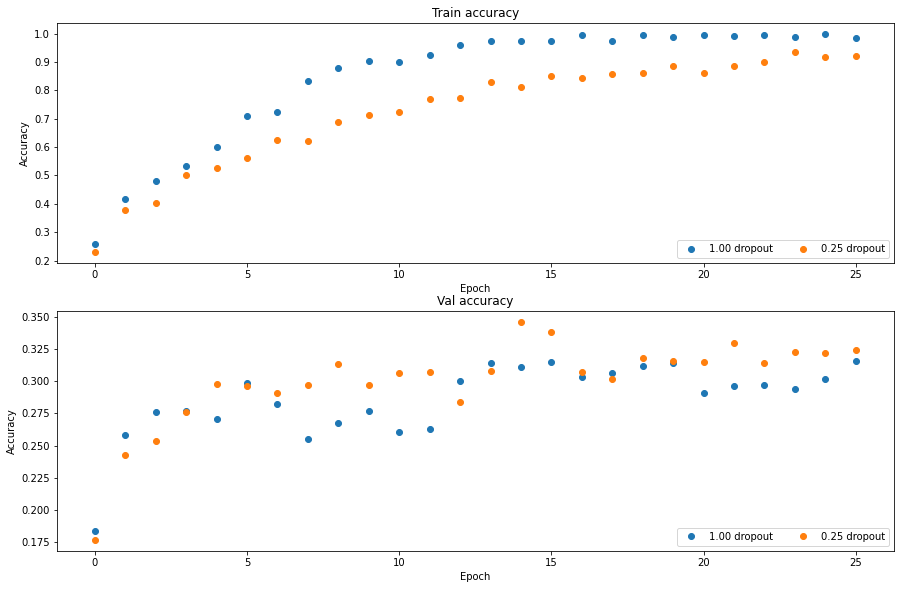

In [21]:
# Plot train and validation accuracies of the two models

train_accs = []
val_accs = []
for dropout in dropout_choices:
  solver = solvers[dropout]
  train_accs.append(solver.train_acc_history[-1])
  val_accs.append(solver.val_acc_history[-1])

plt.subplot(3, 1, 1)
for dropout in dropout_choices:
  plt.plot(solvers[dropout].train_acc_history, 'o', label='%.2f dropout' % dropout)
plt.title('Train accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')
  
plt.subplot(3, 1, 2)
for dropout in dropout_choices:
  plt.plot(solvers[dropout].val_acc_history, 'o', label='%.2f dropout' % dropout)
plt.title('Val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')

plt.gcf().set_size_inches(15, 15)
plt.show()

## Inline Question 3:
Compare the validation and training accuracies with and without dropout -- what do your results suggest about dropout as a regularization technique?

## Answer:
[FILL THIS IN]
